<h2><font color="#004D7F" size=6>Módulo 8. Aprendizaje No Supervisado</font></h2>



<h1><font color="#004D7F" size=5>8.2. Compresión de imágenes con k-means</font></h1>

<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3>Manuel Castillo-Cara</font><br>
<font color="#004D7F" size=3>Machine Learning con Python</font><br>

---

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>

* [1. Introducción](#section1)
* [2. Lectura de la imagen y creación del conjunto de datos](#section2)
* [3. Reducción a cuatro colores](#section3)
* [4. Estudio del coste en función de _k_](#section4)
    * [4.1. _k_ / coste](#section41)
* [5. Práctica](#section5)

---

<a id="section1"></a>
# <font color="#004D7F"> 1. Introducción</font>

Una imagen de tamaño $w \times h$ puntos se representa internamente mediante una matriz bidimensional de ese tamaño, en la que cada elemento corresponde al color del punto correspondiente. La representación del color depende del tipo de imagen. Así, por ejemplo, para las imagenes en gris, el color se puede representar mediante un número que va desde 0 (negro) a 255 (blanco). Esta representación requiere un byte (8 bits, $2^8=256$) para almacenar el color de cada punto. En el caso de las imágenes en color, uno de los formatos que se usa comúnmente es el RGB, en el que cada punto se representa por una tupla de tres elementos _(r, g, b)_ con las intensidades del canal rojo, verde y azul respectivamente. En ese caso, la representación del color de cada punto suele hacerse con bytes (3 números del 0 al 255), y el número de colores distintos que se pueden representar es $256\times256\times256= 16777216$. Además, puesto que cada punto se representa, a su vez, con un vector, se ha de usar una matriz _tridimensional_.
<br>

En esta libreta se utilizará el algoritmo _k-means_ para determinar los colores más representativos de una imagen, con el fin de representarla con un número reducido ($k$) de colores. Esto permite reducir el tamaño de $\left(w \cdot h \cdot 3\right)$ bytes a $\left( w \cdot h \cdot \log_2(k)/8 + (k*3)\right)$ bytes.
<br>

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Importante__. La matriz de puntos/color es el modo en que se trabaja con la imagen en formato `RAW`, internamente, sin ningún tipo de compresión. Los archivos de tipo `.jpg`, `.png`, etc., codifican las imágenes de otra manera, mucho más eficiente que la que se hará en esta práctica, cuyo fin es puramente didáctico.
</div>

In [1]:
# Permite ensanchar el área útil de la libreta
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\eel20\AppData\Local\Temp\ipykernel_15352\3915887226.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


---

---

<a id="section2"></a>
# <font color="#004D7F"> 2. Lectura de la imagen y creación del conjunto de datos</font>
<br>

En la siguiente celda se lee el archivo `fruta.jpg` y se almacena en un array _Numpy_ tridimensional. Debido al modo en que interpreta los datos de las imágenes _Matplotlib_ (que se utilizará para mostrarlas), todos los valores se reescalarán al rango $[0,1]$.

In [2]:
#!pip install imageio

C:\Users\eel20\AppData\Local\Temp\ipykernel_15352\2308503207.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_fruit = imageio.imread("datos/datos/fruta.jpg")


Dimensiones: 620 x 400 (248000 puntos).
Tamaño de la imagen: 744000 bytes.


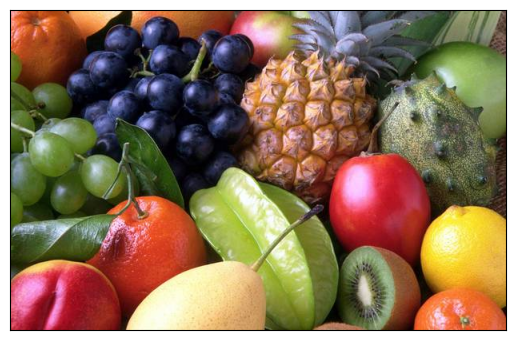

In [5]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

# Lee la imagen y guarda las dimensiones
img_fruit = imageio.imread("datos/datos/fruta.jpg")
width, height, colors =  tuple(img_fruit.shape)
print("Dimensiones: {:d} x {:d} ({:d} puntos).".format(height, width, width*height))
print("Tamaño de la imagen: {:d} bytes.".format(width*height*colors))

# Reescala todos los valores al rango [0,1]
img_fruit = img_fruit/255.0

# Muetra la imagen
plt.imshow(img_fruit); # Mostrar en 2D
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False) # Quitar escalas

Para llevar a cabo el agrupamiento de colores, es necesario convertir la imagen a un conjunto de datos bidimensional de tamaño $(ancho \times alto) \times 3$, en el que cada fila corresponde a un punto, y cada una de las tres columnas a una de las componentes del color. 

In [6]:
data_fruit = np.reshape(img_fruit, (width*height, colors))
print("Tamaño del conjunto de datos: "+str(data_fruit.shape)+"\n")
print("Cinco primeros puntos: \n")
print(data_fruit[:5,:])

Tamaño del conjunto de datos: (248000, 3)

Cinco primeros puntos: 

[[0.95294118 0.58039216 0.61176471]
 [0.94901961 0.57647059 0.6       ]
 [0.92156863 0.54901961 0.57254902]
 [0.87843137 0.50980392 0.51372549]
 [0.85882353 0.49019608 0.48235294]]


---
<a id="section3"></a>

# <font color="#004D7F"> 3. Reducción a cuatro colores</font>
<br>

En este punto, el conjunto de datos contiene el color correspondiente a cada punto. Es decir, cada fila corresponde a un color. A continuación, se utilizará el algoritmo _$k$-medias_ para agrupar esos colores en 4 grupos en función de su similaridad. 

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> 
La Documentación oficial de [k-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
</div>

In [7]:
from sklearn.cluster import KMeans
from time import time

k = 4
start = time()
# Utilizamos como inicialización 'k-means++', que suele dar mejores resultados. 
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500)
kmeans.fit(data_fruit)
stop = time()
print("Tiempo {:0.3f} segundos.".format(stop-start))

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Tiempo 1.478 segundos.


Como resultado del proceso de agrupamiento se devuelven:

* $\mu_k \in \mathbb{R}^3$. El centroide de cada cluster $k$. Cada centroide representa un color RGB.
* $c^{(i)} \in \{1,\ldots,K\}$, es decir, el índice del cluster al que se ha asignado cada elemento $x^{(i)}$ 

In [8]:
# Centroides
centroids = kmeans.cluster_centers_
print("Centroides:")
print(centroids)
print()

# Clusters
clusters = kmeans.labels_
print("Clusters (para los 100 primeros puntos:")
print(clusters[:100])

Centroides:
[[0.70176625 0.26526218 0.17188972]
 [0.18759966 0.17173268 0.1190565 ]
 [0.47574765 0.49392238 0.34625632]
 [0.87832595 0.76439451 0.57881989]]

Clusters (para los 100 primeros puntos:
[3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


La nueva imagen se construye sustituyendo el color correspondiente a cada punto por el centroide del cluster al que pertenece (en este caso, 4 posibles).

In [9]:
data_fruit_compressed = centroids[clusters,:]

In [10]:
data_fruit_compressed

array([[0.87832595, 0.76439451, 0.57881989],
       [0.87832595, 0.76439451, 0.57881989],
       [0.87832595, 0.76439451, 0.57881989],
       ...,
       [0.70176625, 0.26526218, 0.17188972],
       [0.70176625, 0.26526218, 0.17188972],
       [0.70176625, 0.26526218, 0.17188972]])

Por último, se reconvierte el array bidimensional a un array tridimensional para mostrar la imagen.

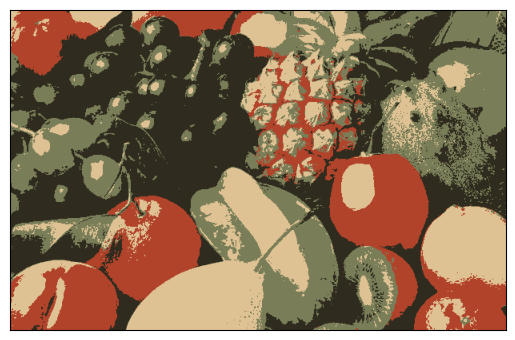

In [11]:
img_fruit_compressed = data_fruit_compressed.reshape((width, height, 3))
plt.imshow(img_fruit_compressed);
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

---

<a id="section4"></a>

# <font color="#004D7F"> 4. Estudio del coste en función de $k$</font>
<br>

En el contexto de agrupamiento, el coste cuantifica la _heterogeneidad_ dentro cada grupo o _cluster_ , y se obtiene
como la suma de las distancias entre cada punto, y el centroide de su cluster, es decir:

$$
J(c^{(1)},\ldots, c^{(m)}, \mu_1, \ldots, \mu_K) = \frac{1}{m} \sum_{i=1}^{m} || x^{(i)}-\mu_{c^{(i)}}||^2
$$


donde $\mu_k$ es el centroide del cluster $k$; $c^{(i)}$ es el cluster al que ha sido asignado el elemento $x^{(i)}$; y $\mu_{c^{(i)}}$ es centroide del cluster al que ha sido asignado $x^{(i)}$.
<br>

La siguiente celda de código implementa la función de coste. Toma como parámetros el conjunto de datos, $k$, los centroides, y la asignación de clusters. En el cálculo se hace uso de la función `pairwise_distances` de `scikit-learn`, que obtiene las distancias entre vectores pertenecientes a dos grupos. En este caso, un grupo contiene los vectores correspondientes a un cluster, y el otro un elemento, correspondiente al centroide. 

In [12]:
from sklearn.metrics import pairwise_distances

def cost(data, k, centroids, clusters):
    cost = 0.0
    for c in range(k):
        points_cluster = data[clusters==c, :]
        if points_cluster.shape[0]>0:
            distances = pairwise_distances(points_cluster, [centroids[c]], metric='euclidean')
            cost += np.sum(distances**2)
    return cost/len(clusters)

cost_k4 = cost(data_fruit, k, centroids, clusters)
print("Coste : {:.2f}.".format(cost_k4))

Coste : 0.05.


<a id="section41"></a>
## <font color="#004D7F"> 4.1. _k_ / coste </font>

Anteriormente se ha ejecutado el algoritmo _k-means_ sobre el conjunto de 248000 puntos. Para agilizar la obtención de los datos correspondientes a la relación _coste/k_ , se va a trabajar sobre una muestra de 5000 puntos. La función `sklearn.utils.shuffle` permite extraer filas al azar de un vector bidimensional. 

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> 
La Documentación oficial de [`sklearn.utils.shuffle`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html)
</div>

In [13]:
from sklearn.utils import shuffle

# Extrae 5000 puntos de manera aleatoria
data_fruit_small = shuffle(data_fruit, random_state=0)[:5000]

kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500).fit(data_fruit_small)
centroids = kmeans.cluster_centers_
clusters = kmeans.labels_


C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
# Centroides
print("Centroides:")
print(centroids)
print()

# Clusters
print("Clusters (para los 100 primeros puntos:")
print(clusters[:100])

Centroides:
[[0.1847354  0.17045553 0.11917501]
 [0.69315228 0.26079433 0.17196419]
 [0.87417162 0.76534809 0.56544715]
 [0.47312876 0.49043586 0.3477023 ]]

Clusters (para los 100 primeros puntos:
[0 2 0 1 0 0 2 2 1 3 0 3 2 0 3 0 2 0 2 3 3 2 3 3 2 3 1 3 3 2 1 2 1 0 3 3 1
 3 3 0 2 1 3 3 0 0 0 1 0 2 2 2 1 1 0 0 1 0 1 3 0 1 2 3 0 2 1 1 3 0 3 3 3 0
 1 2 1 2 1 1 0 2 1 3 0 1 0 3 0 1 1 2 0 0 1 2 2 0 2 1]


Puede verse que el coste s similar al anterior.

In [15]:
cost_k4 = cost(data_fruit_small, k, centroids, clusters)
print("Coste : {:.2f}.".format(cost_k4, cost_k4/5000))

Coste : 0.05.


En la siguiente celda de código se obtiene el coste para ejecuciones de _k-means_ sobre el conjunto de datos reducido, y valores de $k$ que van desde 1 a 64.

..

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


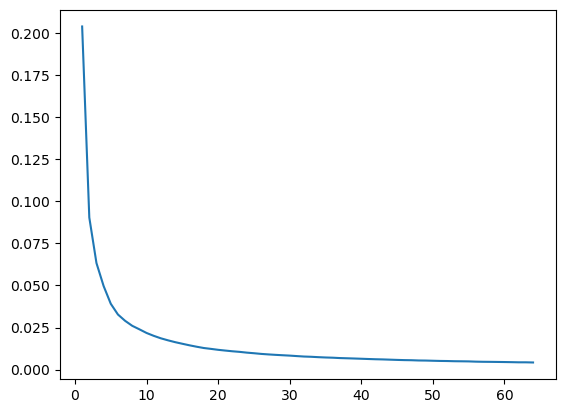

In [16]:
# Arrat que guardará los costes
costs = np.zeros(64,)
# Valores de k de 1 a 64
ks = 1+np.arange(64)

# Ejecuta k-means para cada valor de k, y guarda el coste asociado
for i,k in enumerate(ks):
    print('.', end='')
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500)
    kmeans.fit(data_fruit_small)
    centroids = kmeans.cluster_centers_
    clusters = kmeans.labels_
    costs[i] = cost(data_fruit_small, k, centroids, clusters)
    
# Dibuja la curva    
plt.plot(ks,costs);    

In [17]:
for i in range(64):
    print(costs[i])

0.20383473169334868
0.09035401598214769
0.06331592806751977
0.049668252360055454
0.03912942002105403
0.03274777651302028
0.029002652069435357
0.026030929014453034
0.023945679994528773
0.021780635777647744
0.020081543359440075
0.018601821025807864
0.017402520307901792
0.016318026474484923
0.015369118552520445
0.0144465372716913
0.013606792713737392
0.012841996366980987
0.012324970917236167
0.011773822410518206
0.011325652848427698
0.010904027939023248
0.01055496919532051
0.01010376540828252
0.009749624167075078
0.00935100432789285
0.009049953402314282
0.008786257588445572
0.008551807791566562
0.00833146216073593
0.008046403648771594
0.007781044259459922
0.007634287377491412
0.007407343086302896
0.0072203901654806476
0.007088499439259676
0.006876249224395012
0.006747351232976995
0.006613044318463059
0.0064660919830333815
0.006312481203533909
0.006169968435691471
0.00607026087977251
0.005925293391621556
0.0057794225294367976
0.005659995776708223
0.005592570575526112
0.005441866055103815
0

In [18]:
np.mean(costs)

0.016006490492226844

La gráfica muestra claramente que existe un punto a partir del cual la disminución del coste es significativamente más lenta. En concreto, hasta 10-12 colores, la disminución del coste es considerable. A partir de ese punto, es mucho más lenta. 
<br>

Esta circunstancia se puede apreciar también visualmente en las imágenes. Para ilustrarlo, se utilizarán las imágenes con 4, 16, 32 y 64 colores. Como se utiliza una muestra de 5000 puntos para obtener los clusters más rápido, es necesario, con el fin de mostrar la imagen, asignar al cluster correspondiente cada punto del conjunto de datos original (248000 puntos). Para ello, se utiliza el método `kmeans.predict` que, para cada caso, mide la distancia a los $k$ centroides, y asigna el más cercano.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


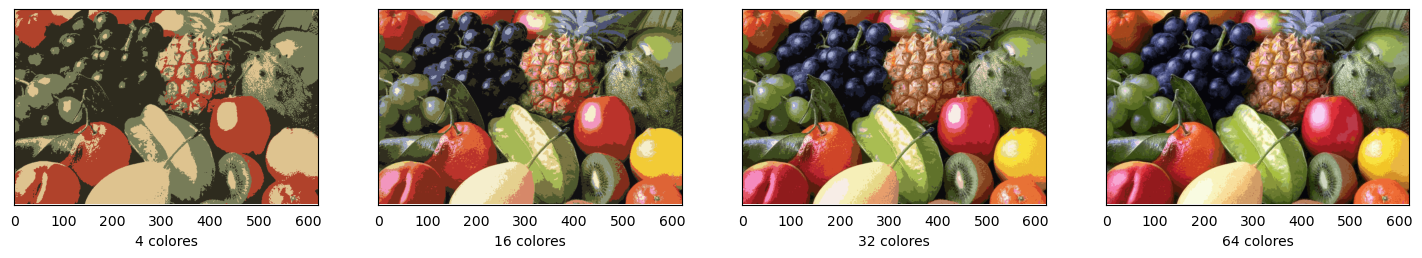

In [19]:
# Crea una figura con cuatro gráficas
f, axes_grid = plt.subplots(1, 4, figsize=(18,6));

for i,k in enumerate([4,16,32,64]):
    # Estima los clusters con conjunto de datos reduccido. 
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500)
    kmeans.fit(data_fruit_small)
    centroids = kmeans.cluster_centers_
    
    # Determina el cluster al que pertenece cada color del conjunto original.
    clusters = kmeans.predict(data_fruit)
  
    # Obtiene y muestra la imagen comprimida
    compressed = centroids[clusters,:].reshape((width, height, 3))
    
    axes_grid[i].imshow(compressed)
    axes_grid[i].set_ylim([width,0])
    axes_grid[i].set_xlim([0,height])
    axes_grid[i].set_xlabel("{:d} colores".format(k))
    axes_grid[i].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)

Puede verse que la diferencia entre la imagen representada con cuatro colores y la imagen representada con 16 colores es mucho más importante que la diferencia entre la representada con 16 colores y la representad con 32. Esto se corresponde a lo esperado según la función de coste. 

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section5"></a>

# <font color="#004D7F"> 5. Práctica</font>
<br>

Como se ha podido ver los algoritmos de aprendizaje no supervisado son una gran herramienta para establecer clases en datos no etiquetados. Además, en esta práctica se ha visto únicamente el algoritmo $k$-means, por lo que se pide:
1. Utilizar el algoritmo clustering jerárquico y comparar el rendimiento con $k$-means.
2. Utilizar el algoritmo basado en conectividad DBSCAN y comparar el rendimiento con $k$-means.
3. Utilizar un algoritmo basado en conectividad diferente a DBSCAN y comparar el rendimiento con los anteriores.

<div style="text-align: left"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#113D68"></i></font></div>

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>